# Functions

**Preparing labels**

In [5]:
def prepare_labels(labels):
    # Assuming labels are a list of strings representing digits
    prepared_labels = []
    for label in labels:
        label_digits = [int(char) for char in str(label)]
        prepared_labels.append(label_digits)
    return tf.ragged.constant(prepared_labels, dtype=tf.int64).to_tensor(default_value=-1)

**Resize images to desire size**

In [6]:
def res_images(images, target_height=108, target_width=363):
    resized_images = []
    for img in images:
        # Ensure the image is a 3D array (height, width, channels)
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)  # Add a channel dimension for grayscale images
        
        # Resize the image
        resized_img = tf.image.resize(img, [target_height, target_width], method='nearest')
        resized_img = resized_img.numpy()  # Convert back to a numpy array

        resized_images.append(resized_img)
    
    return np.array(resized_images)

**Decoding the predictions**

In [7]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :8
    ]
    # Iterate over the results and get back the text
    return results

**Num to char**

In [8]:
def num2char(inp):
    inp = inp.numpy().tolist()
    result = []
    for sub in inp:
        tmp = []
        for char in sub:
            if char != -1:
                tmp.append(str(char))
        result.append(tmp)
    return result

# libraries

In [9]:
import sys
sys.path.append('./../')

In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from Metrics import cer
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Bidirectional, LSTM, Input, Reshape, Dense, Dropout

# Fetch Data

In [11]:
path = './../Dataset/ORAND-CAR-2014/'

In [12]:
xa_train, xa_test = [cv2.cvtColor(cv2.imread(f'{path}/CAR-A/a_train_images/{img}'), cv2. COLOR_BGR2GRAY) for img in os.listdir(f'{path}/CAR-A/a_train_images')], [cv2.cvtColor(cv2.imread(f'{path}/CAR-A/a_test_images/{img}'), cv2. COLOR_BGR2GRAY) for img in os.listdir(f'{path}/CAR-A/a_test_images')]

In [13]:
xb_train, xb_test = [cv2.cvtColor(cv2.imread(f'{path}/CAR-B/b_train_images/{img}'), cv2. COLOR_BGR2GRAY) for img in os.listdir(f'{path}/CAR-B/b_train_images')], [cv2.cvtColor(cv2.imread(f'{path}/CAR-B/b_test_images/{img}'), cv2. COLOR_BGR2GRAY) for img in os.listdir(f'{path}/CAR-B/b_test_images')]

In [14]:
x_train, x_test = xa_train + xb_train, xa_test + xb_test

In [15]:
ya_train, ya_test, yb_train, yb_test = [], [], [], []
with open(f'{path}CAR-A/a_train_gt.txt', 'r') as a_train, open(f'{path}CAR-A/a_test_gt.txt', 'r') as a_test, open(f'{path}CAR-B/b_train_gt.txt', 'r') as b_train, open(f'{path}CAR-B/b_test_gt.txt', 'r') as b_test:
    for i in a_train:
        ya_train.append(i.split()[1])
    for i in a_test:
        ya_test.append(i.split()[1])
    for i in b_train:
        yb_train.append(i.split()[1])
    for i in b_test:
        yb_test.append(i.split()[1])
y_train, y_test = ya_train + yb_train, ya_test + yb_test

plot several samples of training data **Befor** resize

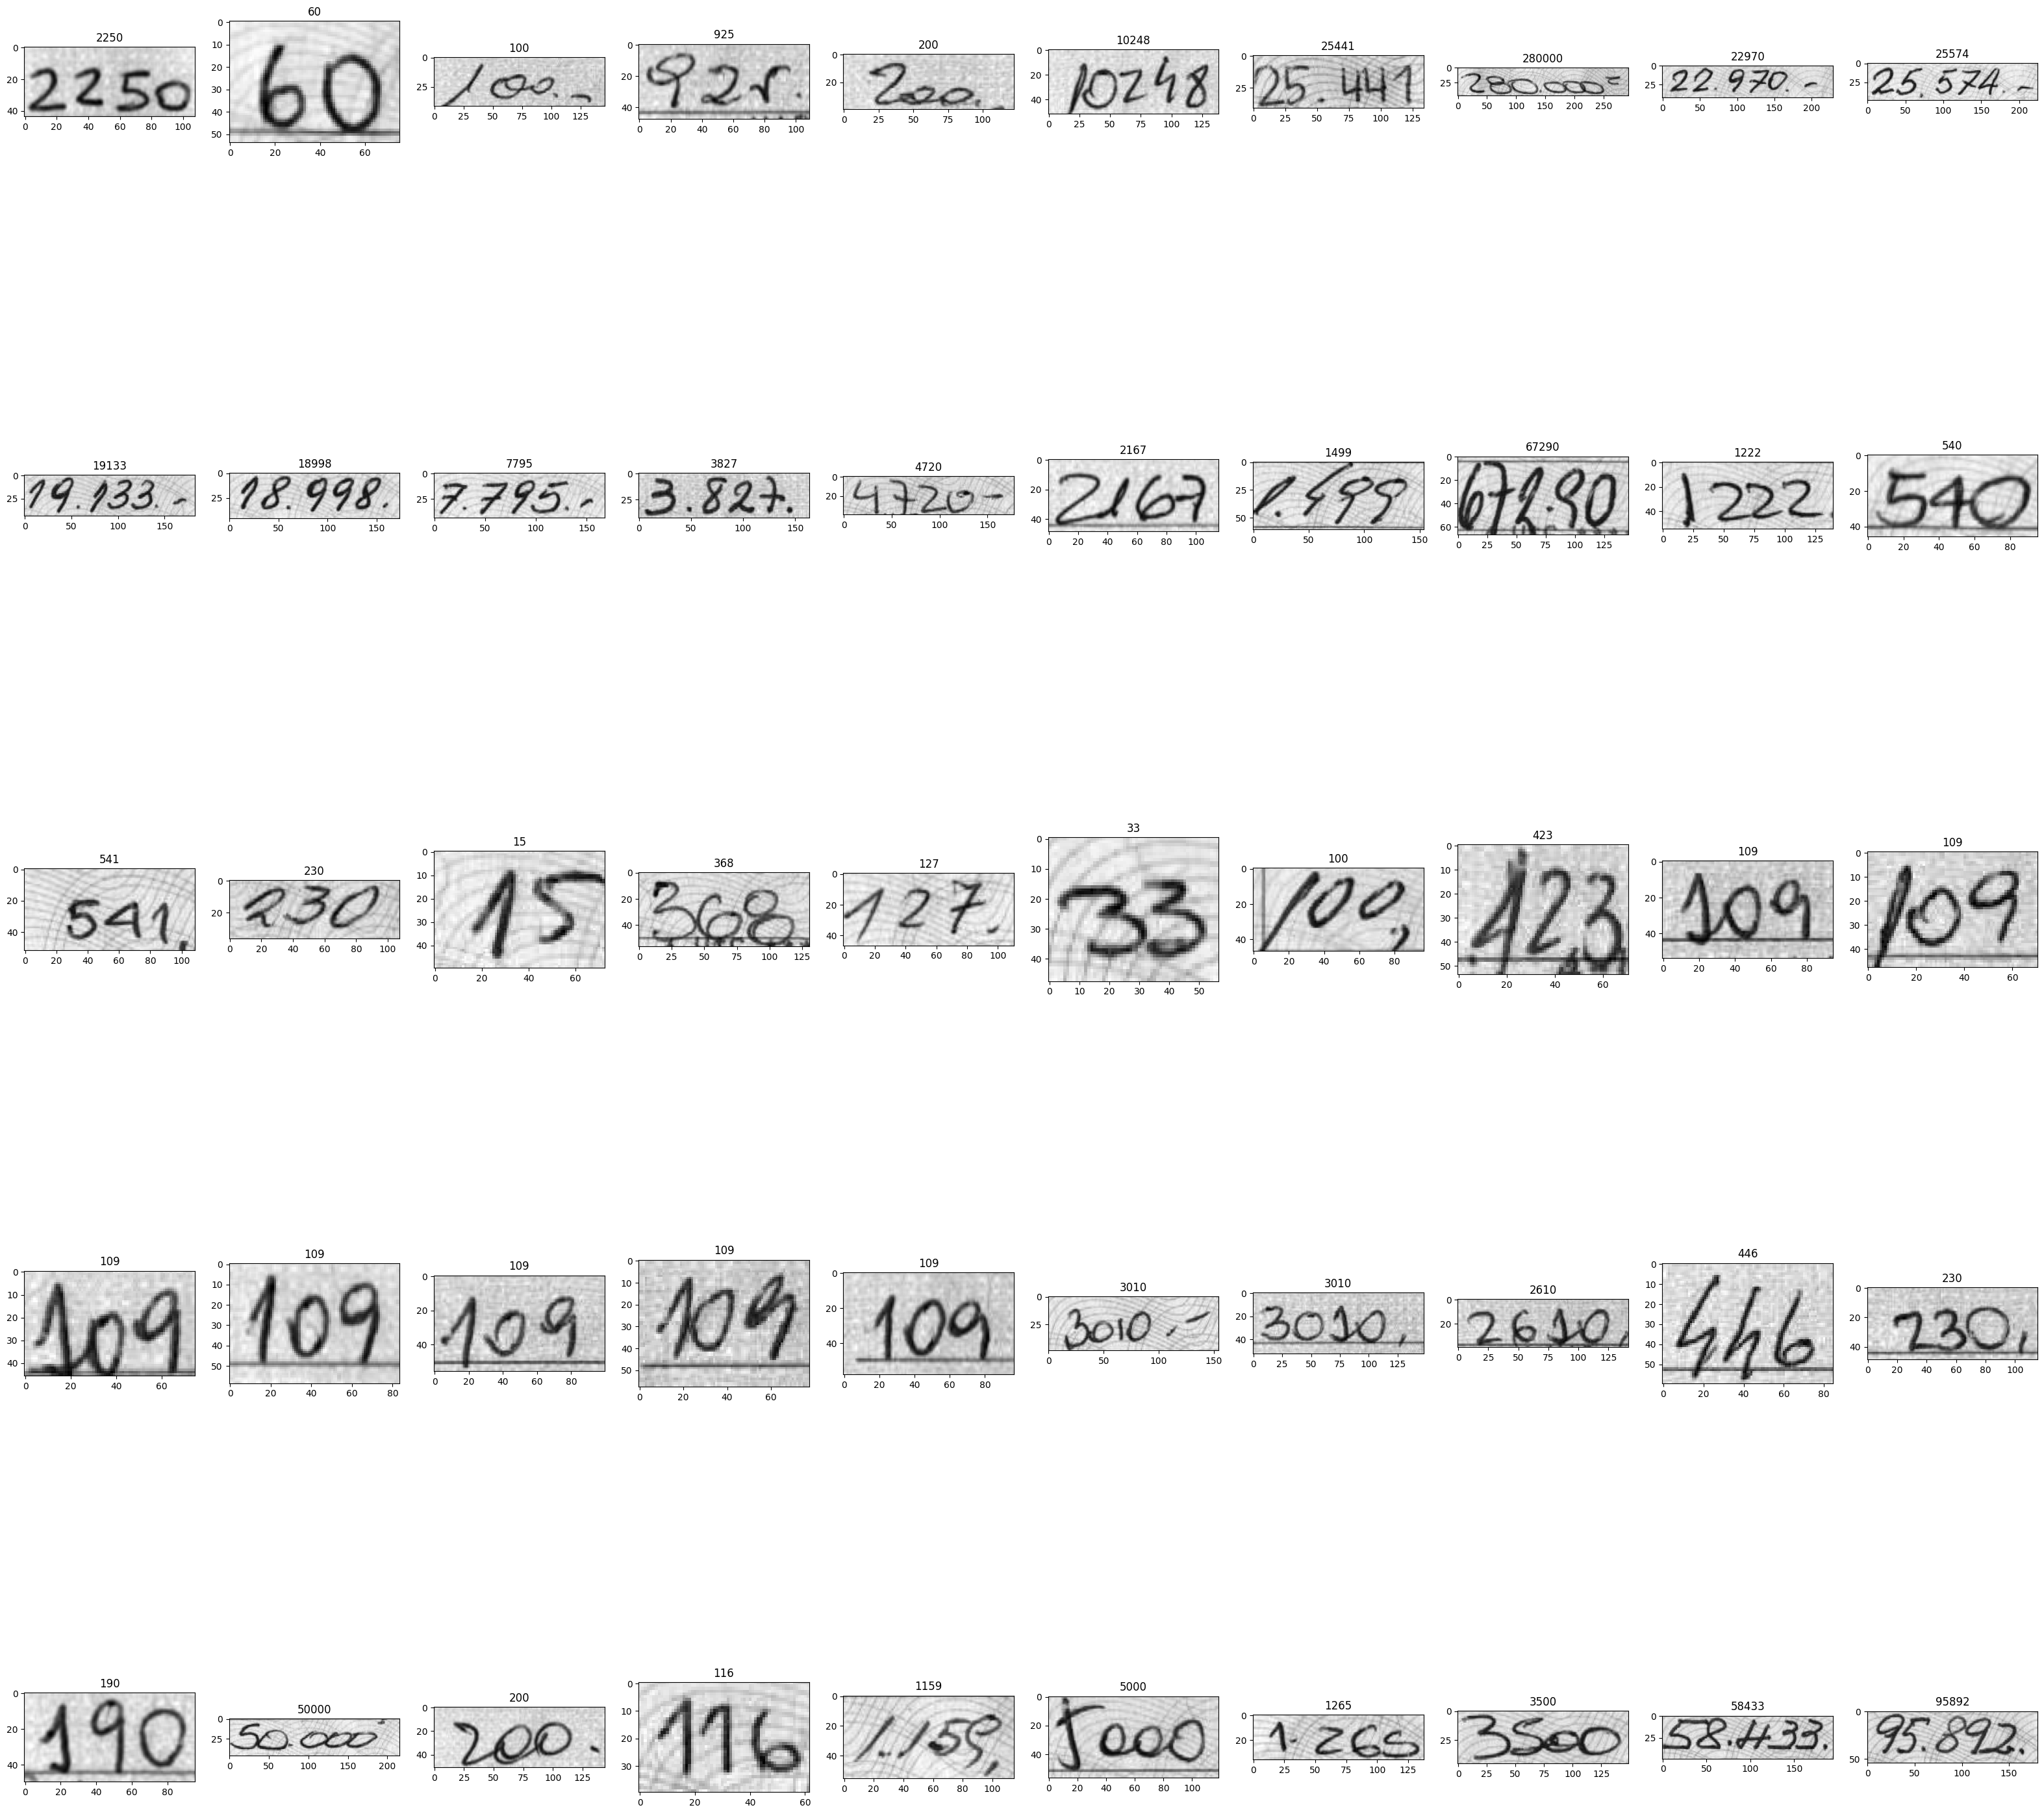

In [16]:
fig, ax = plt.subplots(5,10, figsize=(40, 40))
ax = ax.flatten()
for i in range(50):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].title.set_text(y_train[i])

In [17]:
x_train, x_test = res_images(x_train, 32, 128), res_images(x_test, 32, 128)

plot several samples of training data **After** resize

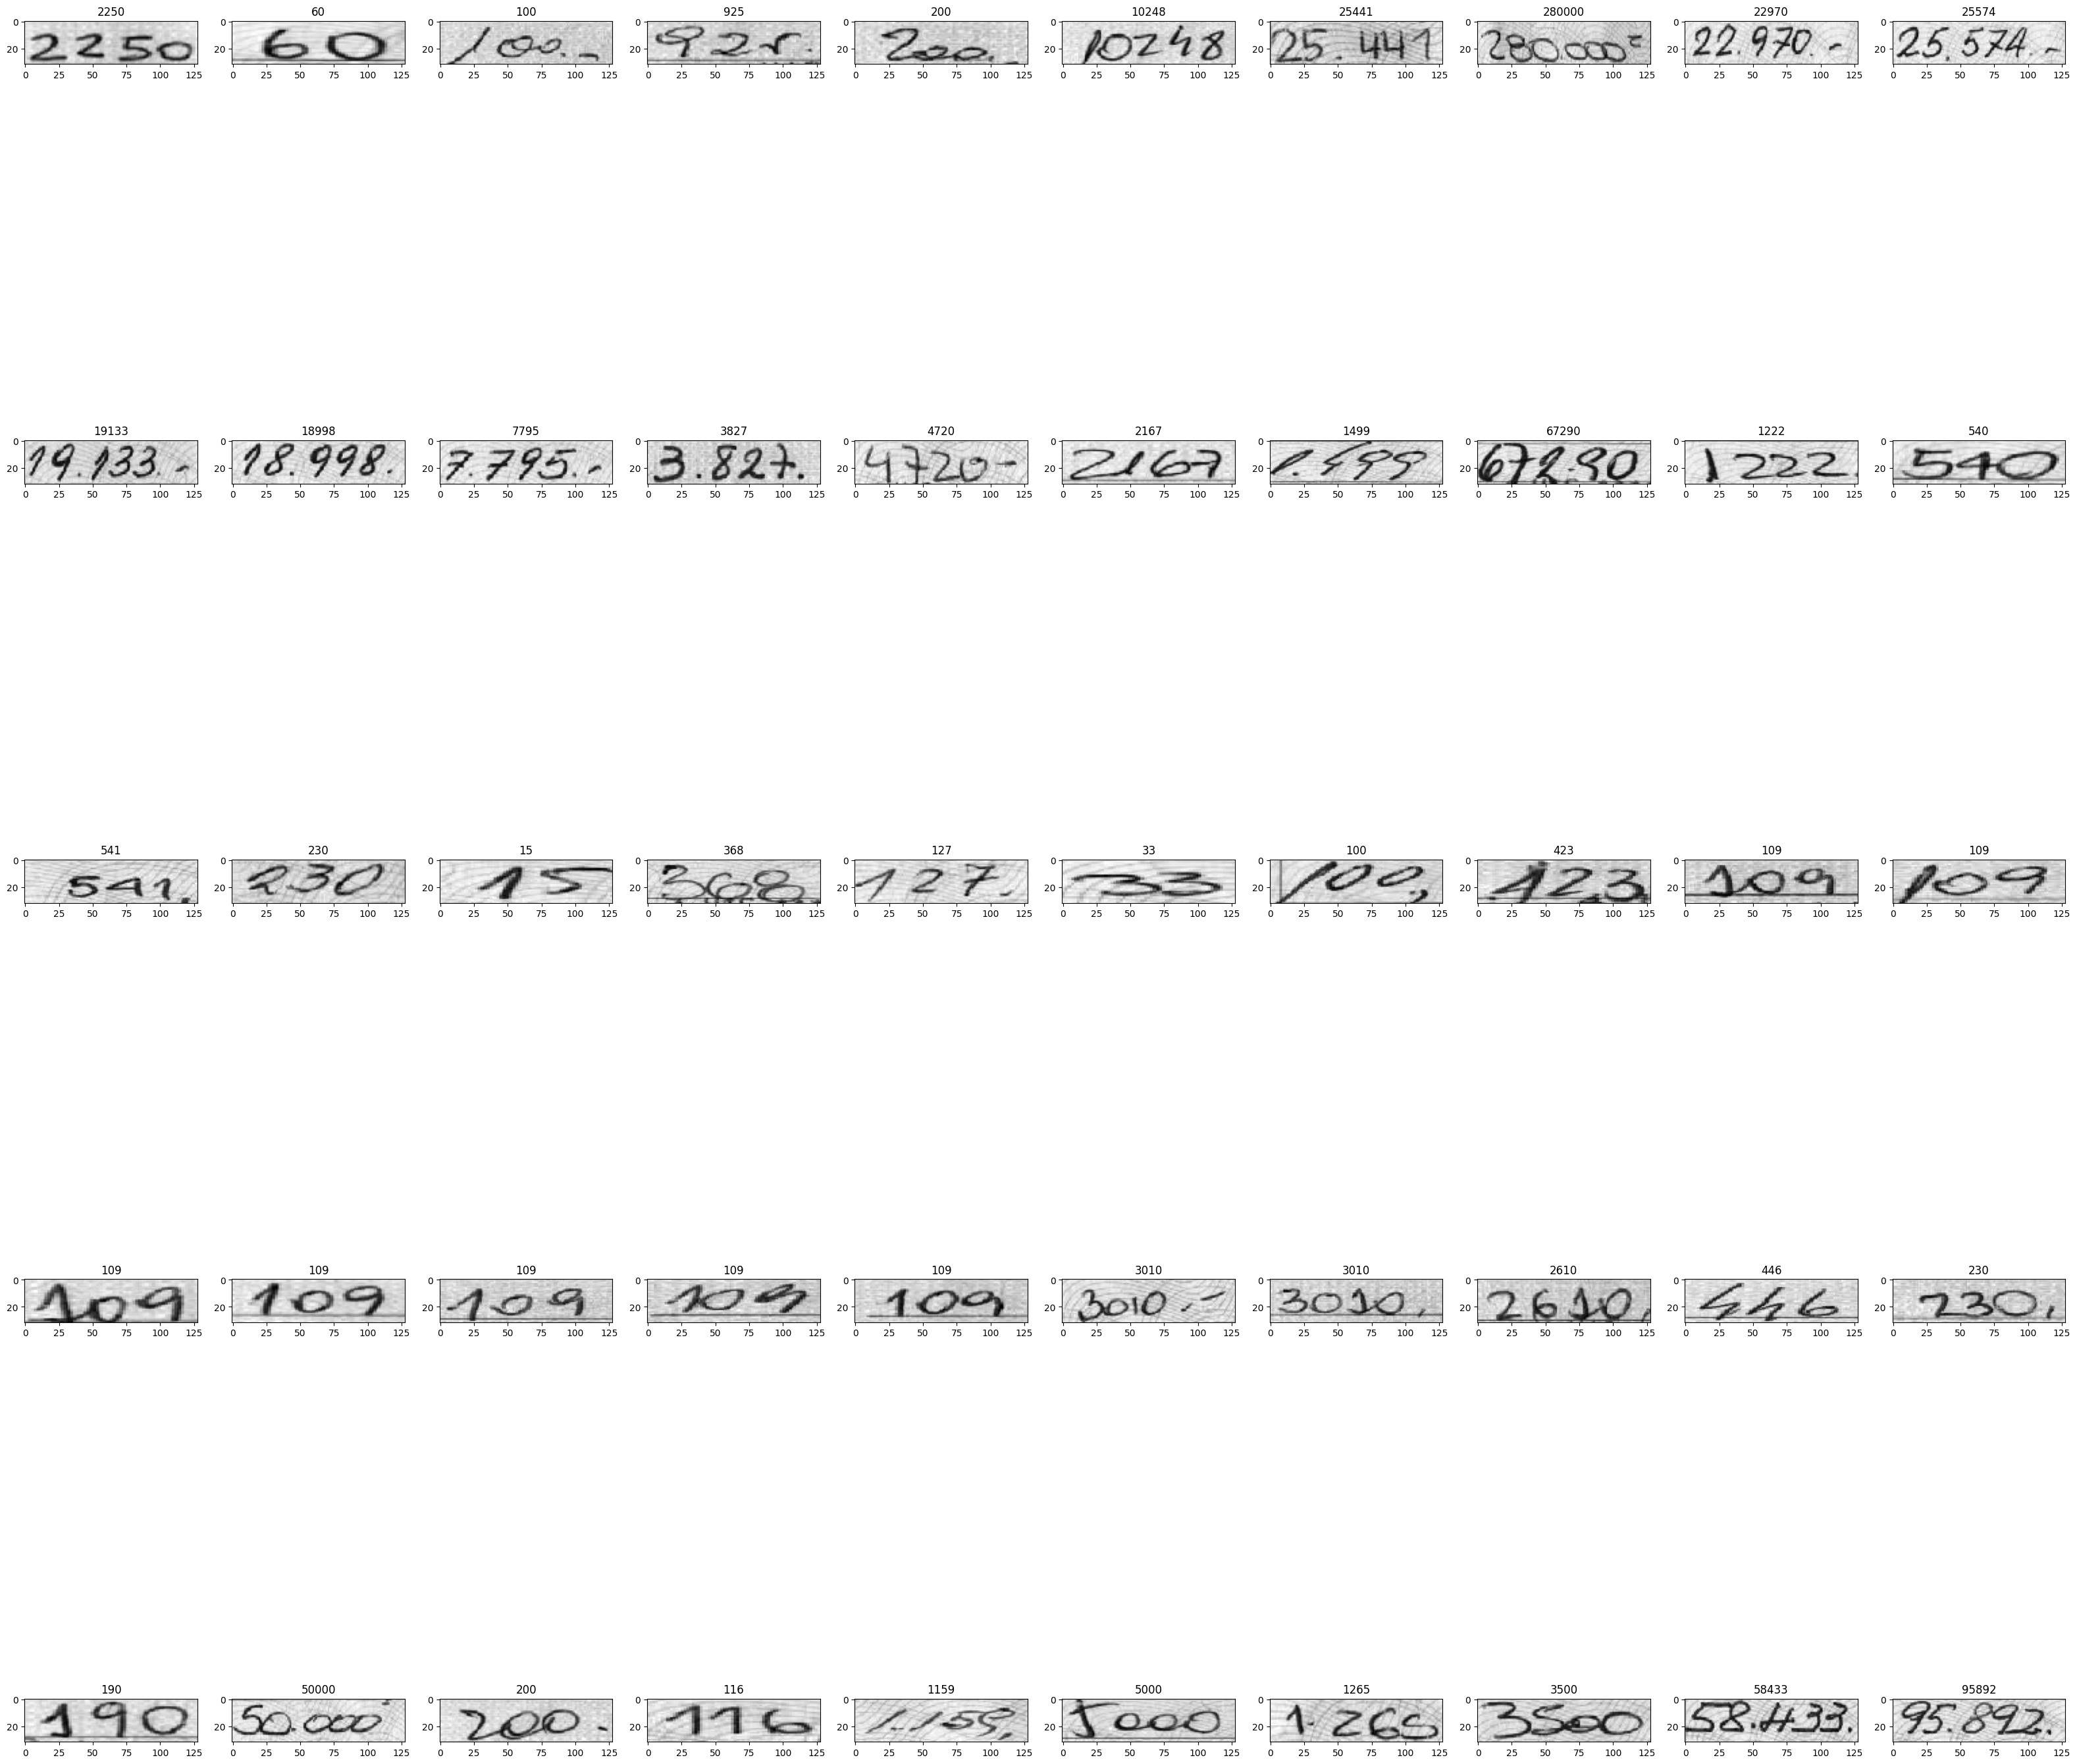

In [18]:
fig, ax = plt.subplots(5,10, figsize=(40, 40))
ax = ax.flatten()
for i in range(50):  
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].title.set_text(y_train[i])

**Normalizing**

In [19]:
x_train, x_test = x_train /255., x_test/255.

In [20]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.3, random_state=42)

**Prepare labels**

In [21]:
y_train = prepare_labels(y_train)
y_val = prepare_labels(y_val)
y_test = prepare_labels(y_test)

In [22]:
def calculate_edit_distance(labels, predictions):
    # Ensure labels are dense tensors with rank 2 (batch_size, max_label_length)
    labels = tf.expand_dims(labels, axis=-1)
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Ensure predictions are dense tensors and have rank 2 (batch_size, max_label_length)
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    max_len = max(len(label) for label in y_train)
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    predictions_decoded = tf.expand_dims(predictions_decoded, axis=-1)
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # Ensure both sparse tensors have the same rank
    labels_rank = tf.rank(sparse_labels)
    predictions_rank = tf.rank(sparse_predictions)

    if labels_rank < predictions_rank:
        sparse_labels = tf.sparse.expand_dims(sparse_labels, axis=-1)
    elif labels_rank > predictions_rank:
        sparse_predictions = tf.sparse.expand_dims(sparse_predictions, axis=-1)

    # Compute the edit distance
    edit_distances = tf.edit_distance(sparse_predictions, sparse_labels, normalize=False)
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.validation_images = validation_images
        self.validation_labels = validation_labels

In [23]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_size = tf.shape(y_true)[0]
        input_length = tf.shape(y_pred)[1]
        label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, -1), dtype=tf.int64), axis=1)

        input_length = tf.fill([batch_size, 1], input_length)
        label_length = tf.expand_dims(label_length, 1)

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [24]:
def build_model():
    image_width, image_height = 128, 32
    # Inputs to the model
    input_img = keras.Input(shape=(image_height, image_width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    x = keras.layers.Dropout(0.3)(x)
    
    x = keras.layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = keras.layers.AveragePooling2D((2, 2), name="avgpool1")(x)
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 8x smaller. The number of
    # filters in the last layer is 512. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 8), (image_height // 8) * 512)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(128, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.3)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)

    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        11, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_digit_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_digit_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 128, 64)  640         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 16, 64, 64)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 16, 64, 128)  73856       ['pool

In [25]:
epochs = 120
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model, x_val, y_val)
# Train the model.
model = build_model()
history = model.fit(
    x={"image": x_train, "label": y_train},
    validation_data=({"image": x_val, "label": y_val}),
    epochs=epochs,
    callbacks=[edit_distance_callback],
    batch_size=256
)


Epoch 1/120
20/20 [==============================] - 20s 479ms/step - loss: 12.9475 - val_loss: 12.0471
Epoch 2/120
20/20 [==============================] - 5s 256ms/step - loss: 11.7719 - val_loss: 11.8269
Epoch 3/120
20/20 [==============================] - 5s 257ms/step - loss: 11.7250 - val_loss: 11.8200
Epoch 4/120
20/20 [==============================] - 5s 253ms/step - loss: 11.7074 - val_loss: 11.7451
Epoch 5/120
20/20 [==============================] - 5s 253ms/step - loss: 11.6876 - val_loss: 11.8589
Epoch 6/120
20/20 [==============================] - 5s 254ms/step - loss: 11.6816 - val_loss: 11.7343
Epoch 7/120
20/20 [==============================] - 5s 252ms/step - loss: 11.6627 - val_loss: 11.7116
Epoch 8/120
20/20 [==============================] - 5s 255ms/step - loss: 11.6599 - val_loss: 11.7305
Epoch 9/120
20/20 [==============================] - 5s 263ms/step - loss: 11.6483 - val_loss: 11.7978
Epoch 10/120
20/20 [==============================] - 5s 259ms/step - lo

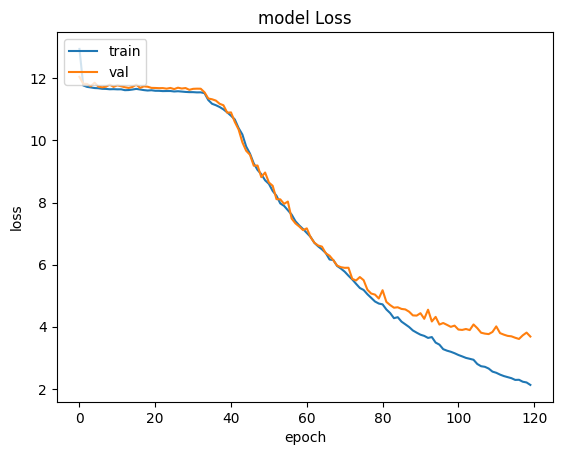

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save Model

In [27]:
model.save('my_model.h5')

# Prediction

In [28]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

**make predictions**

In [29]:
pre = prediction_model.predict(x_test)

147/147 [==============================] - 3s 10ms/step


**Decode predictions**

In [30]:
predicted_labels = decode_batch_predictions(pre)

**Convert Numbers to Characters**

In [31]:
predicted_labels = num2char(predicted_labels)
y_test = num2char(y_test)

In [32]:
res, same = 0, 0
for i in range(len(y_test)):
    if y_test[i] == predicted_labels[i]:
        same += 1
    res += cer(y_test[i], predicted_labels[i])
print(f'Mean of error rate is {res/len(y_test)}')

Mean of error rate is 22.77841986272902


In [33]:
same

1708

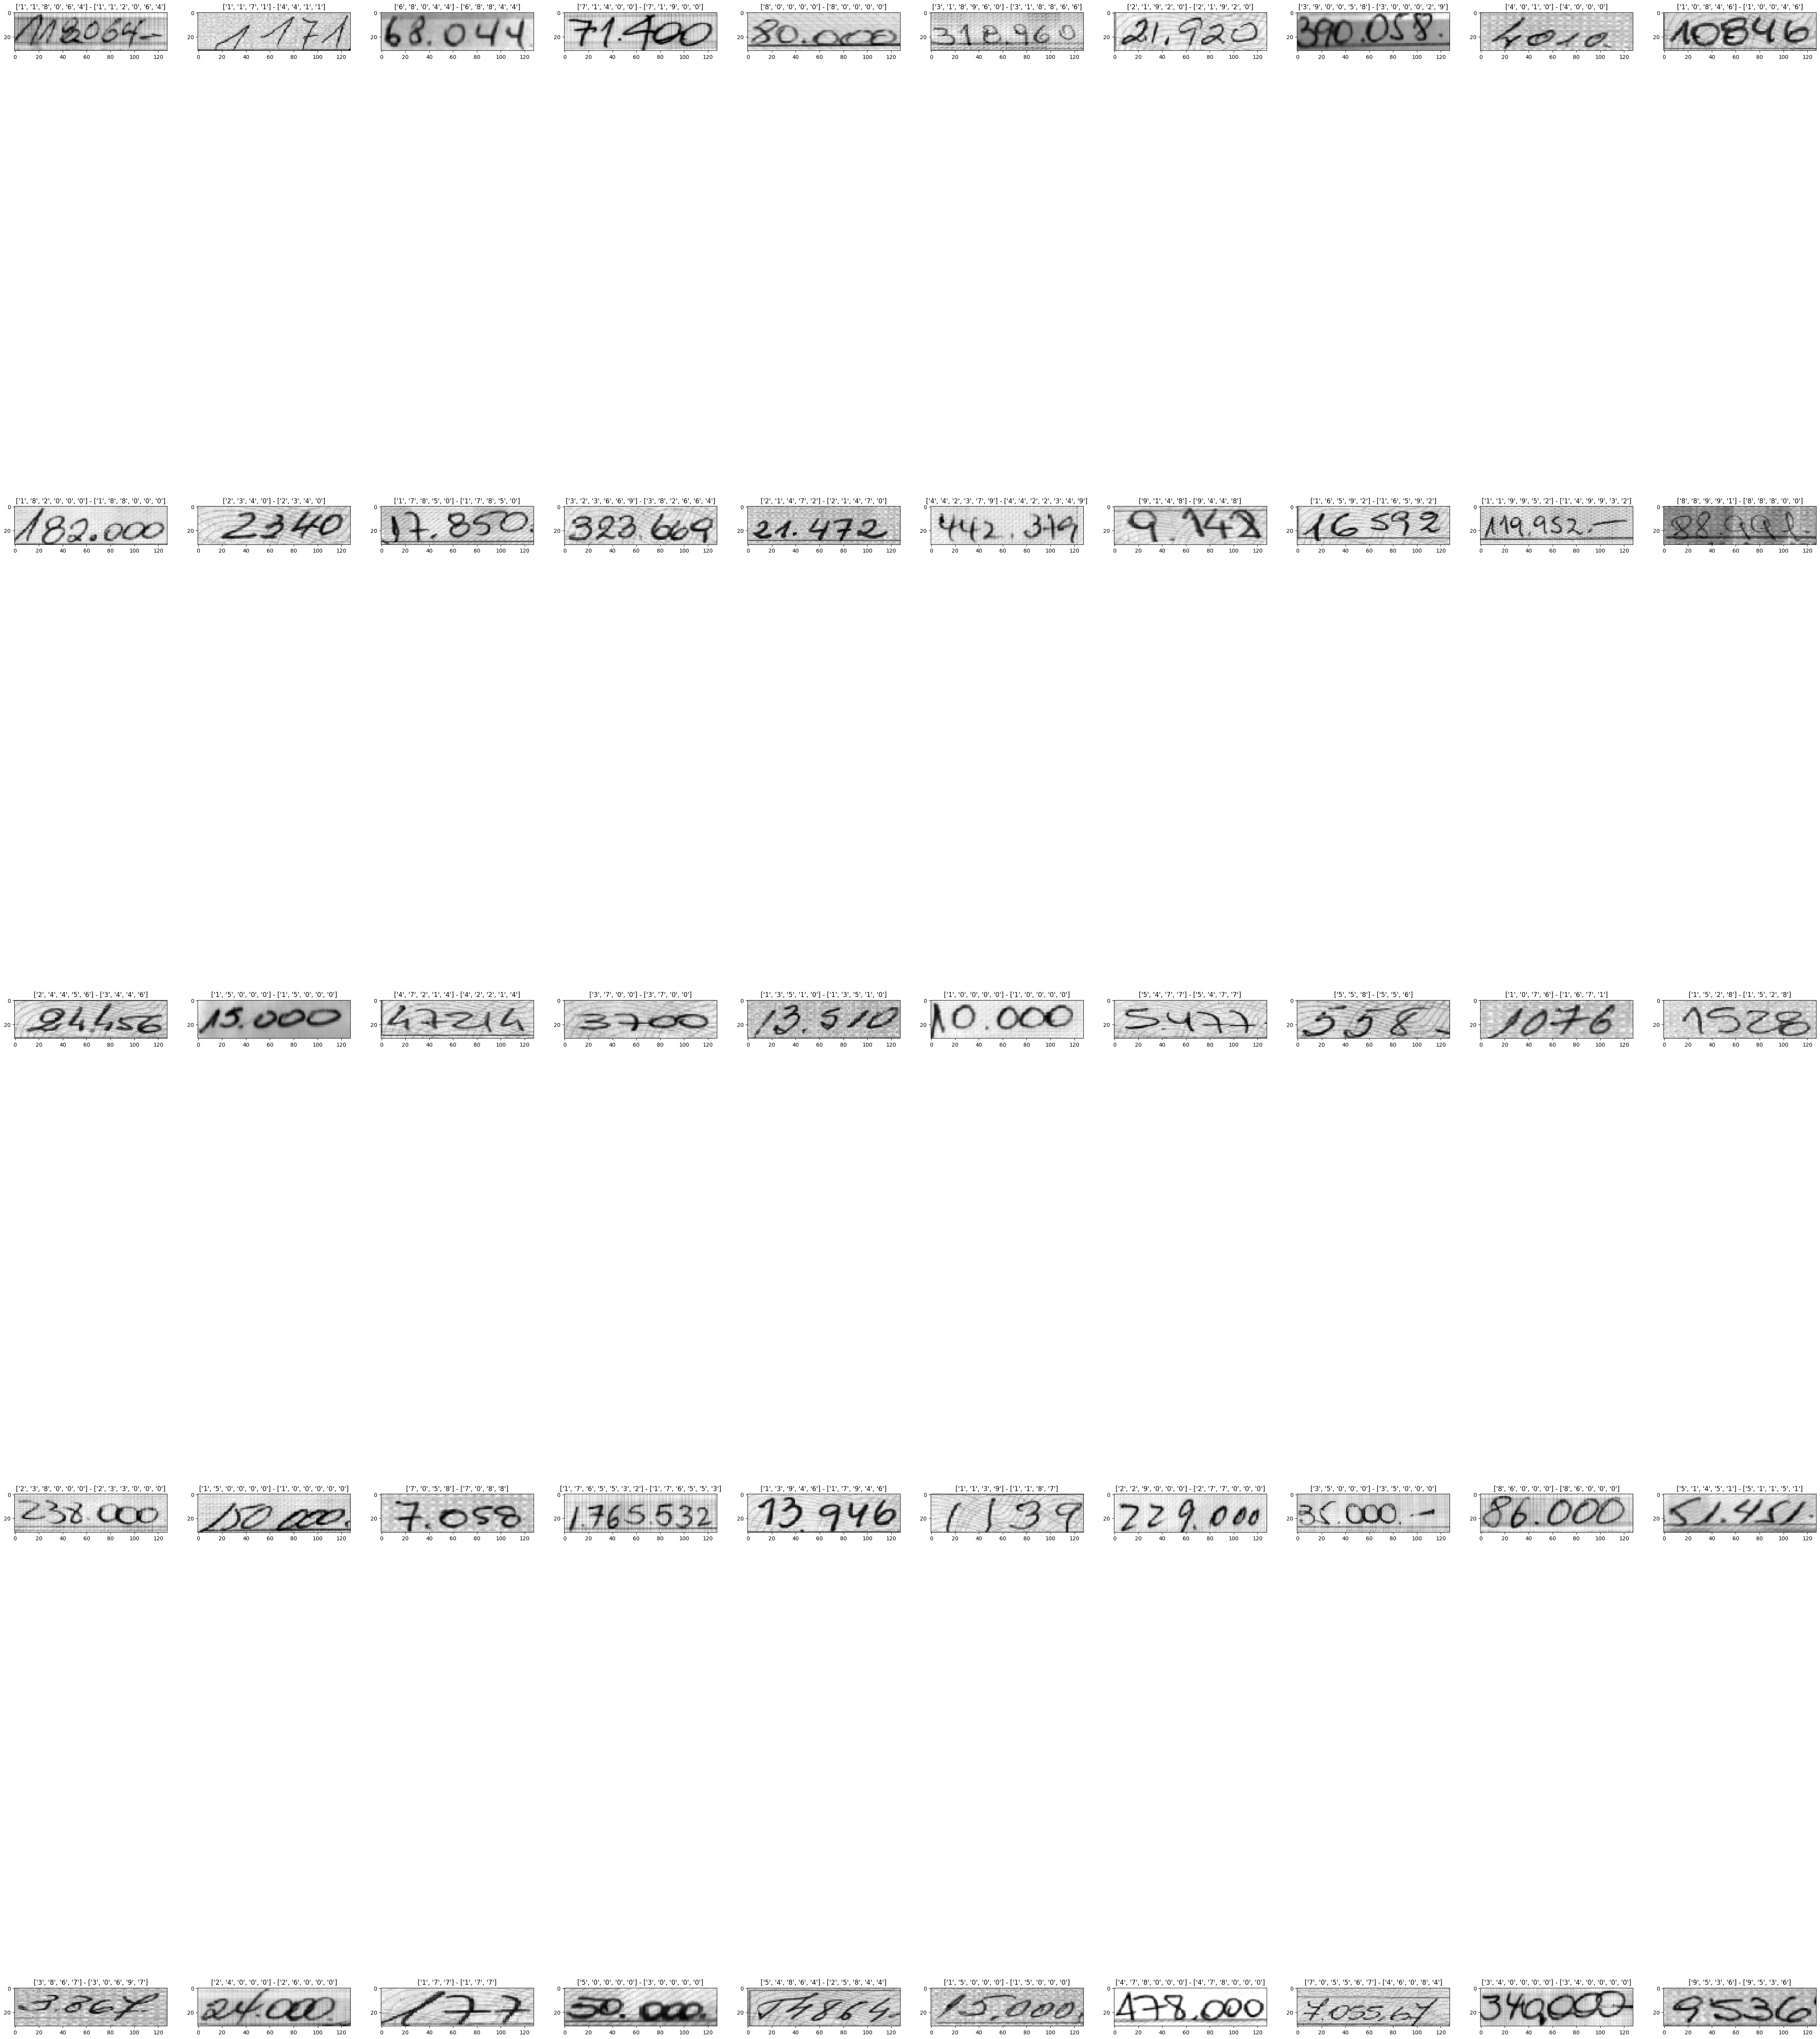

In [36]:
fig, ax = plt.subplots(5,10, figsize=(60, 80))
ax = ax.flatten()
for i in range(50):  
    ax[i].imshow(x_test[i], cmap='gray')
    ax[i].title.set_text(f'{y_test[i]} - {predicted_labels[i]}')